In [1]:
#from __future__ import absolute_import
#from __future__ import division
#from __future__ import print_function
import os
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

#显示中文字体设置
plt.rcParams["font.sans-serif"] = ["Droid Sans Fallback"]
plt.rcParams['axes.unicode_minus'] = False #为了正常显示是"-"减号

plt.ion()   # interactive mode 画图不阻止程序运行
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


In [2]:

collar_design_labels = ['衣领不可见Invisible','衬衫领ShirtCollar','彼得潘女士小圆领PeterPan','清道夫领PuritanCollar','螺纹领RibCollar']
neckline_design_labels = ['颈领线不可见Invisible','无肩带领StraplessNeck','深V领DeepVNeckline', '直领StraightNeck', 'V领VNeckline', 
                          '方领SquareNeckline', '出肩领OffShoulder', '圆领RoundNeckline', '桃形领SweatHeart Neck', '单肩领OneShoulderNeckline']
skirt_length_labels = ['裙不可见Invisible', '短群Short', '及膝群Knee', '旗袍裙群Midi', '及脚群Ankle', '接地群Floor']
sleeve_length_labels = ['袖不可见Invisible', '无袖Sleeveless', '杯袖CupSleeves', '短袖ShortSleeves', '肘中袖ElbowSleeves', '7分袖Sleeves',
                        '及腕9分袖WristLength', '长袖Long Sleeves', '超长袖Extra Long Sleeves']
neck_design_labels = ['脖颈不可见Invisible','长高领TurtleNeck', '荷叶半高领RuffleSemi-HighCollar','低圆领LowTurtleNeck','翻领DrapedCollar']
lapel_design_labels = ['翻领不可见Invisible','缺口领Notched','无领Collarless','披肩围巾式领ShawlCollar','大号披肩围巾式领PlusSizeShawl']
pant_length_labels = ['裤不可见Invisible', '短裤ShortPant', '中裤MidLength', '7分裤3/4Length', '9分裤CroppedPant', '长裤FullLength']
coat_length_labels = ['衣不可见Invisible','高腰衣HighWaist Length','常规衣RegularLength','长衣LongLength','加长衣MicroLength',
                      '及膝衣Knee Length','旗袍衣MidiLength','及地衣Ankle&FloorLength']

classes = ['collar_design_labels', 'neckline_design_labels', 'skirt_length_labels', 
           'sleeve_length_labels', 'neck_design_labels', 'lapel_design_labels', 
           'pant_length_labels','coat_length_labels'] 

label_count = {'coat_length_labels':8,
               'collar_design_labels':5, 
               'lapel_design_labels':5,
               'neck_design_labels':5,
               'neckline_design_labels':10,
               'pant_length_labels':6, 
               'skirt_length_labels':6, 
               'sleeve_length_labels':9}
#####################
width = 299
#####################


In [3]:
df_train = {}
df_load = {}
df_testload = {}
attrs_count = {}
attrs_test_count = {}

attrs_cls_count = {}

attrs_y = {}


attrs_cls_label_map = {
    'skirt_length_labels':['裙不可见Invisible', '短群Short', '及膝群Knee', '旗袍裙群Midi', '及脚群Ankle', '接地群Floor'],
    'coat_length_labels': ['衣不可见Invisible','高腰衣HighWaistLength','常规衣RegularLength','长衣LongLength','加长衣MicroLength',
                           '及膝衣Knee Length','旗袍衣MidiLength','及地衣Ankle&FloorLength'],
    'collar_design_labels': ['衣领不可见Invisible','衬衫领ShirtCollar','彼得潘女士小圆领PeterPan','清道夫领PuritanCollar','螺纹领RibCollar'],
    'lapel_design_labels':['翻领不可见Invisible','缺口领Notched','无领Collarless','披肩围巾式领ShawlCollar','大号披肩围巾式领PlusSizeShawl'],
    'neck_design_labels':['脖颈不可见Invisible','长高领TurtleNeck', '荷叶半高领RuffleSemi-HighCollar','低圆领LowTurtleNeck','翻领Draped Collar'],
    'neckline_design_labels':['颈领线不可见Invisible','无肩带领StraplessNeck','深V领DeepVNeckline', '直领StraightNeck', 'V领VNeckline', 
                              '方领SquareNeckline', '出肩领OffShoulder', '圆领RoundNeckline', '桃形领SweatHeartNeck', '单肩领OneShoulderNeckline'],
    'pant_length_labels':[ '裤不可见Invisible', '短裤ShortPant', '中裤Mid Length', '7分裤3/4Length', '9分裤CroppedPant', '长裤FullLength'],
    'sleeve_length_labels':['袖不可见Invisible', '无袖Sleeveless', '杯袖CupSleeves', '短袖ShortSleeves', '肘中袖ElbowSleeves',
                            '7分袖Sleeves', '及腕9分袖WristLength', '长袖LongSleeves', '超长袖ExtraLongSleeves']  
}


for i in range(len(classes)):
    m_count = 0
    df_train[classes[i]] = pd.read_csv('../train/Annotations/{0}.csv'.format(classes[i]), header=None)
    df_train[classes[i]].columns = ['image_id', 'class', 'label']
    df_load[classes[i]] = df_train[classes[i]].copy()
    df_load[classes[i]].reset_index(inplace=True)
    del df_load[classes[i]]['index']
    
    #统计测试集样本数用
    df_test = pd.read_csv('../test/Tests/question.csv', header=None)
    df_test.columns = ['image_id', 'class', 'label']
    df_testload[classes[i]] = df_test[classes[i] == df_test['class']].copy()
    df_testload[classes[i]].reset_index(inplace=True)
    del df_testload[classes[i]]['index']
    
    n = len(df_load[classes[i]])
    n_class = len(df_load[classes[i]]['label'][0])
    #prefix_cls = class[i].split('_')[0]
    attrs_count[classes[i]] = n
    attrs_test_count[classes[i]] = len(df_testload[classes[i]])
    print("训练集,属性:{0}, 共{1}类, 该属性下共{2}个样本".format(classes[i],n_class, n))
    print("测试集,属性:{0}, 该属性下共{1}个样本".format(classes[i], len(df_testload[classes[i]])))
                                                
    attrs_y[classes[i]] = np.zeros((n, n_class), dtype=np.uint8)
    #attrs_cls_count[classes[i]] = np.zeros(n_class,dtype=np.uint8)
    count = 0
    for j in range(n):
        
        tmp_label = df_load[classes[i]]['label'][j]
        if tmp_label.find('y') != -1:
            count = count +1
            jth = tmp_label.find('y')
            attrs_y[classes[i]][j][jth] = 1
            #下面这种形式有错，不知道为甚。。。
            #attrs_cls_count[classes[i]][jth] = attrs_cls_count[classes[i]][jth]+1 
        if tmp_label.find('m') != -1:
            m_count = m_count +1
    ##这种形式是有效的，列计数
    
    attrs_cls_count[classes[i]] = attrs_y[classes[i]].sum(axis=0)
    print("该类有m标记的样本总数：{}个".format(m_count))
    
    print(attrs_cls_count[classes[i]])
    #print(attrs_y[classes[i]])
    print('')
print("---------------------------------------------------------------------------------------")
for key,value in attrs_cls_count.items(): 
    print("该训练集的 {0} 属性 共 {1} 个类, {2} 个样本, 其中:".format(key, len(value), attrs_count[key]))
    for num in range(len(value)): 
        print("{0}属性的第{1}类:  {2},  其样本数: {3} ".format(key, num+1, attrs_cls_label_map[key][num], value[num]))
    
    print("-------------")






训练集,属性:collar_design_labels, 共5类, 该属性下共8393个样本
测试集,属性:collar_design_labels, 该属性下共1082个样本
该类有m标记的样本总数：193个
[1741 1995 1526 1321 1810]

训练集,属性:neckline_design_labels, 共10类, 该属性下共17148个样本
测试集,属性:neckline_design_labels, 该属性下共2095个样本
该类有m标记的样本总数：350个
[2106 1926 2472 1105 1897 1625 1706 1376 1634 1301]

训练集,属性:skirt_length_labels, 共6类, 该属性下共19333个样本
测试集,属性:skirt_length_labels, 该属性下共1153个样本
该类有m标记的样本总数：677个
[1895 3072 3424 3119 3366 4457]

训练集,属性:sleeve_length_labels, 共9类, 该属性下共13299个样本
测试集,属性:sleeve_length_labels, 该属性下共1740个样本
该类有m标记的样本总数：417个
[   0 1443 2843 1498 1311 1633 1156 1518 1897]

训练集,属性:neck_design_labels, 共5类, 该属性下共5696个样本
测试集,属性:neck_design_labels, 该属性下共708个样本
该类有m标记的样本总数：106个
[ 802 1304 1192 1454  944]

训练集,属性:lapel_design_labels, 共5类, 该属性下共7034个样本
测试集,属性:lapel_design_labels, 该属性下共900个样本
该类有m标记的样本总数：7个
[1174 1525 1887  940 1508]

训练集,属性:pant_length_labels, 共6类, 该属性下共7460个样本
测试集,属性:pant_length_labels, 该属性下共949个样本
该类有m标记的样本总数：236个
[1519 1348 1087 1321  948 1237]

训练集,属性:coat_leng

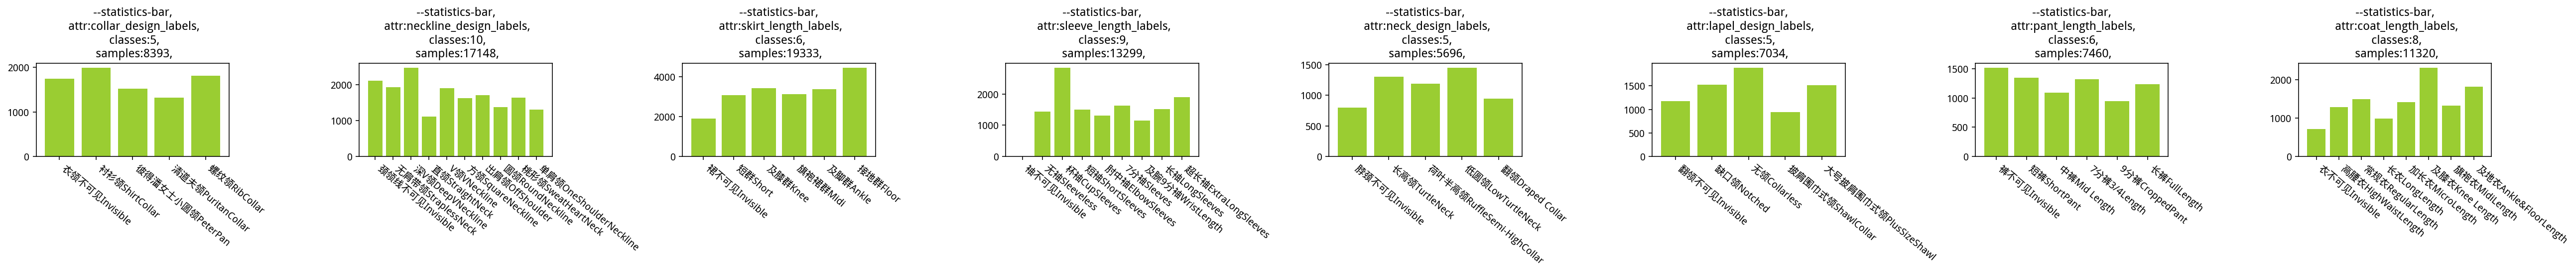

In [4]:
fig,(ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7) = plt.subplots(ncols=8,figsize=(36,4)) 
#fig,axes = plt.subplots(ncols=8,figsize=(32,4)) #此时axes是list
ax = {'collar_design_labels':ax0,'neckline_design_labels':ax1,
      'skirt_length_labels':ax2,'sleeve_length_labels':ax3,
      'neck_design_labels':ax4,'lapel_design_labels':ax5,
      'pant_length_labels':ax6,'coat_length_labels':ax7}
for key,value in attrs_cls_count.items(): 
    #print("attr:{0} ,classes:{1} , samples:{2}".format(key, len(value), attrs_count[key]))
    x = np.arange(len(value))
    #colors='yellowgreen','gold','lightskyblue','lightcoral'
    ax[key].bar(x,value,align='center',facecolor='yellowgreen')
    #自定义坐标和刻度值set_yticks，set_yticklabels
    ax[key].set_xticks(x)
    #ax[key].set_xticklabels(attrs_cls_label_map[key], rotation=30)#这会造成不对其
    ax[key].set_xticklabels(attrs_cls_label_map[key])
    for label in ax[key].xaxis.get_ticklabels():
        label.set_fontsize(10)
        label.set_rotation(-40)
        #下面这句话很重要，不然旋转标签后会不对齐
        label.set_horizontalalignment("left")
    ax[key].set_title(" --statistics-bar, \n attr:{0},\n classes:{1},\n samples:{2},".format(key, len(value), attrs_count[key]))
    #ax[key].set_xlabel("呵呵")
    #ax[key].set_xlabel("哒哒")
#fig.subplots_adjust(hspace=0.4)
#fig.xlabel('Classes/Attributes')
#plt.ylabel('Total Samples')
#plt.title('Statistic-TrainSet-Classes-Samples')
plt.tight_layout()
fig.savefig('../attrs_cls_count_visualization.png',bbox_inches='tight',dpi=72)
plt.show()

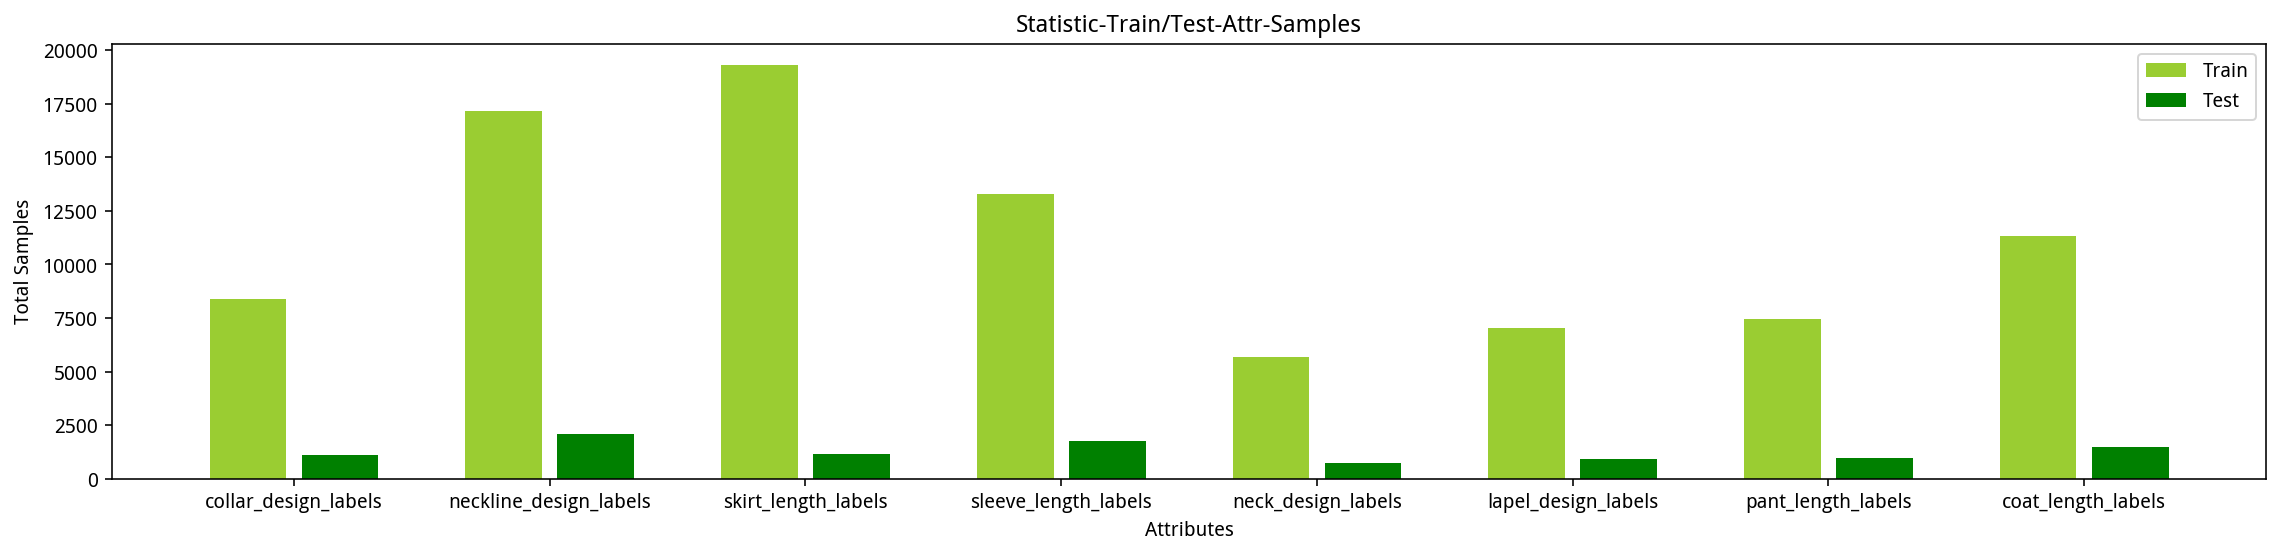

In [5]:
fig2,axx = plt.subplots(figsize=(16,4)) 
axx.bar(range(len(attrs_count)),[value for value in attrs_count.values()],width = 0.3,facecolor='yellowgreen')
k = np.arange(len(attrs_test_count))
axx.bar(k+0.36,[value1 for value1 in attrs_test_count.values()],width = 0.3,facecolor='green')
plt.xlabel('Attributes')
plt.ylabel('Total Samples')
plt.title('Statistic-Train/Test-Attr-Samples')
plt.xticks(k+0.18, classes)
plt.tight_layout()
plt.legend(('Train','Test'))
plt.show()
fig2.savefig('../attrs_count_visualization.png',bbox_inches='tight',dpi=72)